In [30]:
import pandas as pd
import torch
from transformers import AutoModel, AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import joblib
import os

In [31]:
print(torch.cuda.is_available())
print(torch.version.cuda)

True
12.9


In [32]:
file_path = 'DB for chromophore_Sci_Data_rev02.csv'

df = pd.read_csv(file_path)

df = df[df["Quantum yield"].notna() & df["Chromophore"].notna() & df["Solvent"].notna()]
df = df[["Chromophore", "Solvent", "Quantum yield"]]
df = df[df["Quantum yield"] >= 0.01]
print("Filtered dataset size:", len(df))

extra_path = 'dataset2.xlsx'
if os.path.exists(extra_path):
    df_extra_raw = pd.read_excel(extra_path)
    cols_lower = {c.lower().strip(): c for c in df_extra_raw.columns}

    def pick(col_candidates):
        for name in col_candidates:
            if name.lower() in cols_lower:
                return cols_lower[name.lower()]
        return None

    chrom_col = pick(["chromophore", "smiles"])
    solv_col  = pick(["solvent"])
    qy_col    = pick(["quantum yield", "plqy", "plq y", "qy"])

    if chrom_col and solv_col and qy_col:
        df_extra = df_extra_raw[[chrom_col, solv_col, qy_col]].rename(
            columns={chrom_col: "Chromophore", solv_col: "Solvent", qy_col: "Quantum yield"}
        )
        df_extra = df_extra[df_extra["Quantum yield"].notna()
                            & df_extra["Chromophore"].notna()
                            & df_extra["Solvent"].notna()]
        df_extra = df_extra[df_extra["Quantum yield"] >= 0.01]
        print("Extra dataset usable rows:", len(df_extra))

   
        df = pd.concat([df, df_extra], ignore_index=True)
    else:
        print("dataset2.xlsx found but required columns (SMILES/chromophore, solvent, PLQY/Quantum yield) not detected; using only base CSV.")
else:
    print("Extra dataset 'dataset2.xlsx' not found; using only base CSV.")

print("Total combined filtered dataset size:", len(df))
df.head()

Filtered dataset size: 12541
Extra dataset usable rows: 2912
Total combined filtered dataset size: 15453


,Chromophore,Solvent,Quantum yield
0,O=C([O-])c1ccccc1-c1c2ccc(=O)cc-2oc2cc([O-])ccc12,O,0.950
1,O=C([O-])c1ccccc1C1=c2cc3c4c(c2Oc2c1cc1c5c2CCC...,CO,1.000
2,O=C([O-])c1ccccc1-c1c2cc(Br)c(=O)c(Br)c-2oc2c(...,O,0.200
3,O=C([O-])c1ccccc1-c1c2cc(I)c(=O)c(I)c-2oc2c(I)...,O,0.020
4,O=C([O-])c1c(Cl)c(Cl)c(Cl)c(Cl)c1-c1c2cc(I)c(=...,O,0.018


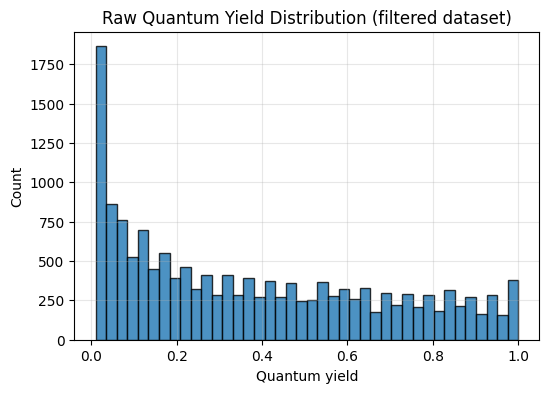

In [33]:

plt.figure(figsize=(6,4))
plt.hist(df["Quantum yield"], bins=40, alpha=0.8, edgecolor="black")
plt.xlabel("Quantum yield")
plt.ylabel("Count")
plt.title("Raw Quantum Yield Distribution (filtered dataset)")
plt.grid(True, alpha=0.3)
plt.show()


In [34]:
model = AutoModel.from_pretrained("ibm/MoLFormer-XL-both-10pct", deterministic_eval=True, trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained("ibm/MoLFormer-XL-both-10pct", trust_remote_code=True)


In [35]:

import torch

CACHE_FILE = "embedding_cache.pt"

def load_cache():
    if os.path.exists(CACHE_FILE):
        return torch.load(CACHE_FILE)
    else:
        return {} 

def save_cache(cache):
    torch.save(cache, CACHE_FILE)

In [36]:
def get_embeddings(smiles_list, batch_size=32, max_length=202):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    cache = load_cache()
    all_embeddings = []


    to_compute = [s for s in smiles_list if s not in cache]

    if len(to_compute) > 0:
        print(f"Computing {len(to_compute)} new embeddings on {device}...")


        model.to(device)
        model.eval()

        with torch.no_grad():
            for i in range(0, len(to_compute), batch_size):
                batch = to_compute[i:i+batch_size]

                inputs = tokenizer(
                    batch, padding=True, truncation=True,
                    max_length=max_length, return_tensors="pt"
                ).to(device)


                outputs = model(**inputs)
                embeddings = outputs.pooler_output 


                for s, emb in zip(batch, embeddings):
                    cache[s] = emb.cpu()


        save_cache(cache)

    else:
        print("All embeddings already in cache.")


    ordered = [cache[s] for s in smiles_list]
    return torch.stack(ordered)


In [37]:
chrom_emb = get_embeddings(df["Chromophore"].tolist())
print("Chromophore embeddings shape:", chrom_emb.shape)

solv_emb = get_embeddings(df["Solvent"].tolist())
print("Solvent embeddings shape:", solv_emb.shape)

combined_emb = torch.cat([chrom_emb, solv_emb], dim=1)
print("Combined embedding shape:", combined_emb.shape)

All embeddings already in cache.
Chromophore embeddings shape: torch.Size([15453, 768])
All embeddings already in cache.
Solvent embeddings shape: torch.Size([15453, 768])
Combined embedding shape: torch.Size([15453, 1536])


In [38]:
from sklearn.preprocessing import StandardScaler

chrom_emb_scaled = torch.tensor(StandardScaler().fit_transform(chrom_emb.numpy()), dtype=torch.float32)
solv_emb_scaled = torch.tensor(StandardScaler().fit_transform(solv_emb.numpy()), dtype=torch.float32)
combined_emb = torch.cat([chrom_emb_scaled, solv_emb_scaled], dim=1)
y = torch.tensor(df["Quantum yield"].values, dtype=torch.float32).unsqueeze(1)

In [39]:

RANDOM_STATE = 42

chrom_trainval, chrom_test, solv_trainval, solv_test, y_trainval, y_test = train_test_split(
    chrom_emb_scaled, solv_emb_scaled, y, test_size=0.20, random_state=RANDOM_STATE
)

val_frac_of_trainval = 0.10 / 0.80  
chrom_train, chrom_val, solv_train, solv_val, y_train, y_val = train_test_split(
    chrom_trainval, solv_trainval, y_trainval, test_size=val_frac_of_trainval, random_state=RANDOM_STATE
)

N_total = chrom_emb_scaled.shape[0]
print(f"Total samples: {N_total}")
print(f"Train samples: {len(chrom_train)} ({len(chrom_train)/N_total:.2%})")
print(f"Val   samples: {len(chrom_val)} ({len(chrom_val)/N_total:.2%})")
print(f"Test  samples: {len(chrom_test)} ({len(chrom_test)/N_total:.2%})")

train_ds = TensorDataset(chrom_train, solv_train, y_train)
val_ds   = TensorDataset(chrom_val,   solv_val,   y_val)
test_ds  = TensorDataset(chrom_test,  solv_test,  y_test)

BATCH_SIZE = 32
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

Total samples: 15453
Train samples: 10816 (69.99%)
Val   samples: 1546 (10.00%)
Test  samples: 3091 (20.00%)


In [40]:
for name, loader in (("train", train_loader), ("val", val_loader), ("test", test_loader)):
    xb_ch, xb_sv, yb = next(iter(loader))
    print(f"{name} batch shapes -> chrom: {xb_ch.shape}, solv: {xb_sv.shape}, y: {yb.shape}")

train batch shapes -> chrom: torch.Size([32, 768]), solv: torch.Size([32, 768]), y: torch.Size([32, 1])
val batch shapes -> chrom: torch.Size([32, 768]), solv: torch.Size([32, 768]), y: torch.Size([32, 1])
test batch shapes -> chrom: torch.Size([32, 768]), solv: torch.Size([32, 768]), y: torch.Size([32, 1])


In [41]:
#Transformer

In [ ]:

class TransformerRegressorImproved(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, num_heads=8, num_layers=2, dropout=0.3):
        super().__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim, nhead=num_heads, dim_feedforward=512, 
            dropout=dropout, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.regressor = nn.Sequential(
            nn.Linear(hidden_dim * 2, 256),
            nn.ReLU(),
            nn.Dropout(0.4), 
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3), 
            nn.Linear(128, 1)
        )
    
    def forward(self, chrom, solv):
        chrom = self.embedding(chrom).unsqueeze(1)
        solv = self.embedding(solv).unsqueeze(1)
        x = torch.cat([chrom, solv], dim=1)
        x = self.transformer(x)
        x = x.flatten(1)
        return self.regressor(x)
    
    def predict(self, chrom, solv, device='cpu'):
        """Predict on numpy arrays or tensors (returns numpy)"""
        self.eval()
        with torch.no_grad():
            if not isinstance(chrom, torch.Tensor):
                chrom = torch.tensor(chrom, dtype=torch.float32)
            if not isinstance(solv, torch.Tensor):
                solv = torch.tensor(solv, dtype=torch.float32)
            chrom = chrom.to(device)
            solv = solv.to(device)
            pred = self.forward(chrom, solv)
            return pred.cpu().numpy()


In [43]:
class TransformerRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, num_heads=8, num_layers=2):
        super().__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim, nhead=num_heads, dim_feedforward=512, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.regressor = nn.Sequential(
            nn.Linear(hidden_dim * 2, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    
    def forward(self, chrom, solv):
        chrom = self.embedding(chrom).unsqueeze(1)
        solv = self.embedding(solv).unsqueeze(1)
        x = torch.cat([chrom, solv], dim=1)
        x = self.transformer(x)
        x = x.flatten(1)
        return self.regressor(x)
    
    def predict(self, chrom, solv, device='cpu'):
        """Predict on numpy arrays or tensors (returns numpy)"""
        self.eval()
        with torch.no_grad():
            if not isinstance(chrom, torch.Tensor):
                chrom = torch.tensor(chrom, dtype=torch.float32)
            if not isinstance(solv, torch.Tensor):
                solv = torch.tensor(solv, dtype=torch.float32)
            chrom = chrom.to(device)
            solv = solv.to(device)
            pred = self.forward(chrom, solv)
            return pred.cpu().numpy()


In [44]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

input_dim = chrom_emb_scaled.shape[1]

transformer_improved = TransformerRegressorImproved(input_dim=input_dim, hidden_dim=256, num_heads=8, num_layers=2, dropout=0.3).to(device)

criterion = nn.MSELoss()
optimizer_improved = torch.optim.Adam(transformer_improved.parameters(), lr=1e-4, weight_decay=1e-5)

epochs = 200
train_losses_improved = []
val_losses_improved = []

early_stopping_patience = 30
best_val_loss_improved = float('inf')
patience_counter_improved = 0
best_epoch_improved = 0

best_model_path_improved = "models/transformer_improved_best.pth"

print(f"Starting training IMPROVED model with early stopping (patience={early_stopping_patience} epochs)...")
print("Regularization: dropout=0.3 in encoder, 0.4/0.3 in regressor, weight_decay=1e-5, gradient clipping")
print("=" * 70)

for epoch in range(epochs):
    # Training phase
    transformer_improved.train()
    total_loss = 0
    
    for chrom_batch, solv_batch, yb in train_loader:
        chrom_batch, solv_batch, yb = chrom_batch.to(device), solv_batch.to(device), yb.to(device)
        
        # Forward pass
        pred = transformer_improved(chrom_batch, solv_batch)
        loss = criterion(pred, yb)
        
        # Backward pass
        optimizer_improved.zero_grad()
        loss.backward()
        # Gradient clipping to prevent exploding gradients and improve stability
        torch.nn.utils.clip_grad_norm_(transformer_improved.parameters(), max_norm=1.0)
        optimizer_improved.step()
        total_loss += loss.item()
    
    avg_train_loss = total_loss / len(train_loader)
    train_losses_improved.append(avg_train_loss)
    
    # Validation phase
    transformer_improved.eval()
    val_total_loss = 0
    with torch.no_grad():
        for chrom_batch, solv_batch, yb in val_loader:
            chrom_batch, solv_batch, yb = chrom_batch.to(device), solv_batch.to(device), yb.to(device)
            pred = transformer_improved(chrom_batch, solv_batch)
            loss = criterion(pred, yb)
            val_total_loss += loss.item()
    
    avg_val_loss = val_total_loss / len(val_loader)
    val_losses_improved.append(avg_val_loss)
    
    # Early stopping logic
    if avg_val_loss < best_val_loss_improved:
        best_val_loss_improved = avg_val_loss
        best_epoch_improved = epoch + 1
        patience_counter_improved = 0
        # Save best model
        torch.save(transformer_improved.state_dict(), best_model_path_improved)
    else:
        patience_counter_improved += 1
    
    # Print progress
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch + 1}/{epochs} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f} | "
              f"Best Val Loss: {best_val_loss_improved:.6f} (Epoch {best_epoch_improved}) | Patience: {patience_counter_improved}/{early_stopping_patience}")
    
    # Check for early stopping
    if patience_counter_improved >= early_stopping_patience:
        print(f"\n{'='*70}")
        print(f"Early stopping triggered! No improvement for {early_stopping_patience} epochs.")
        print(f"Best validation loss: {best_val_loss_improved:.6f} at epoch {best_epoch_improved}")
        print(f"Stopping training at epoch {epoch + 1}")
        print(f"{'='*70}")
        break

print(f"\nTraining complete! Best improved model saved at: {best_model_path_improved}")
print(f"Best validation loss: {best_val_loss_improved:.6f} at epoch {best_epoch_improved}")
print(f"Total epochs trained: {len(train_losses_improved)}")


Using device: cuda
Starting training IMPROVED model with early stopping (patience=30 epochs)...
Regularization: dropout=0.3 in encoder, 0.4/0.3 in regressor, weight_decay=1e-5, gradient clipping
Epoch 1/200 | Train Loss: 0.097708 | Val Loss: 0.070732 | Best Val Loss: 0.070732 (Epoch 1) | Patience: 0/30
Epoch 10/200 | Train Loss: 0.047634 | Val Loss: 0.049230 | Best Val Loss: 0.049230 (Epoch 10) | Patience: 0/30
Epoch 20/200 | Train Loss: 0.031668 | Val Loss: 0.041341 | Best Val Loss: 0.041278 (Epoch 19) | Patience: 1/30
Epoch 30/200 | Train Loss: 0.023893 | Val Loss: 0.039614 | Best Val Loss: 0.038768 (Epoch 29) | Patience: 1/30
Epoch 40/200 | Train Loss: 0.018716 | Val Loss: 0.036295 | Best Val Loss: 0.036295 (Epoch 40) | Patience: 0/30
Epoch 50/200 | Train Loss: 0.015719 | Val Loss: 0.037912 | Best Val Loss: 0.036295 (Epoch 40) | Patience: 10/30
Epoch 60/200 | Train Loss: 0.013307 | Val Loss: 0.034826 | Best Val Loss: 0.034826 (Epoch 60) | Patience: 0/30
Epoch 70/200 | Train Loss: 0.

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

input_dim = chrom_emb_scaled.shape[1]
transformer_model = TransformerRegressor(input_dim=input_dim, hidden_dim=256, num_heads=8, num_layers=2).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(transformer_model.parameters(), lr=1e-4)

epochs = 200
train_losses = []
val_losses = []

early_stopping_patience = 30
best_val_loss = float('inf')
patience_counter = 0
best_epoch = 0

os.makedirs("models", exist_ok=True)
best_model_path = "models/transformer_best.pth"

print(f"Starting training with early stopping (patience={early_stopping_patience} epochs)...")
print("=" * 70)

for epoch in range(epochs):

    transformer_model.train()
    total_loss = 0
    
    for chrom_batch, solv_batch, yb in train_loader:
        chrom_batch, solv_batch, yb = chrom_batch.to(device), solv_batch.to(device), yb.to(device)
        

        pred = transformer_model(chrom_batch, solv_batch)
        loss = criterion(pred, yb)
        

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    

    transformer_model.eval()
    val_total_loss = 0
    with torch.no_grad():
        for chrom_batch, solv_batch, yb in val_loader:
            chrom_batch, solv_batch, yb = chrom_batch.to(device), solv_batch.to(device), yb.to(device)
            pred = transformer_model(chrom_batch, solv_batch)
            loss = criterion(pred, yb)
            val_total_loss += loss.item()
    
    avg_val_loss = val_total_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_epoch = epoch + 1
        patience_counter = 0

        torch.save(transformer_model.state_dict(), best_model_path)
    else:
        patience_counter += 1
    

    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch + 1}/{epochs} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f} | "
              f"Best Val Loss: {best_val_loss:.6f} (Epoch {best_epoch}) | Patience: {patience_counter}/{early_stopping_patience}")
    

    if patience_counter >= early_stopping_patience:
        print(f"\n{'='*70}")
        print(f"Early stopping triggered! No improvement for {early_stopping_patience} epochs.")
        print(f"Best validation loss: {best_val_loss:.6f} at epoch {best_epoch}")
        print(f"Stopping training at epoch {epoch + 1}")
        print(f"{'='*70}")
        break


print(f"\nTraining complete! Best model saved at: {best_model_path}")
print(f"Best validation loss: {best_val_loss:.6f} at epoch {best_epoch}")
print(f"Total epochs trained: {len(train_losses)}")

Using device: cuda
Starting training with early stopping (patience=30 epochs)...
Epoch 1/200 | Train Loss: 0.083558 | Val Loss: 0.068754 | Best Val Loss: 0.068754 (Epoch 1) | Patience: 0/30
Epoch 10/200 | Train Loss: 0.027581 | Val Loss: 0.044219 | Best Val Loss: 0.043906 (Epoch 9) | Patience: 1/30
Epoch 20/200 | Train Loss: 0.015482 | Val Loss: 0.038870 | Best Val Loss: 0.037910 (Epoch 16) | Patience: 4/30
Epoch 30/200 | Train Loss: 0.010927 | Val Loss: 0.036593 | Best Val Loss: 0.036382 (Epoch 27) | Patience: 3/30
Epoch 40/200 | Train Loss: 0.008332 | Val Loss: 0.036822 | Best Val Loss: 0.036382 (Epoch 27) | Patience: 13/30
Epoch 50/200 | Train Loss: 0.006878 | Val Loss: 0.036441 | Best Val Loss: 0.035007 (Epoch 44) | Patience: 6/30
Epoch 60/200 | Train Loss: 0.005917 | Val Loss: 0.034551 | Best Val Loss: 0.034445 (Epoch 58) | Patience: 2/30
Epoch 70/200 | Train Loss: 0.004991 | Val Loss: 0.036523 | Best Val Loss: 0.034046 (Epoch 61) | Patience: 9/30
Epoch 80/200 | Train Loss: 0.0040

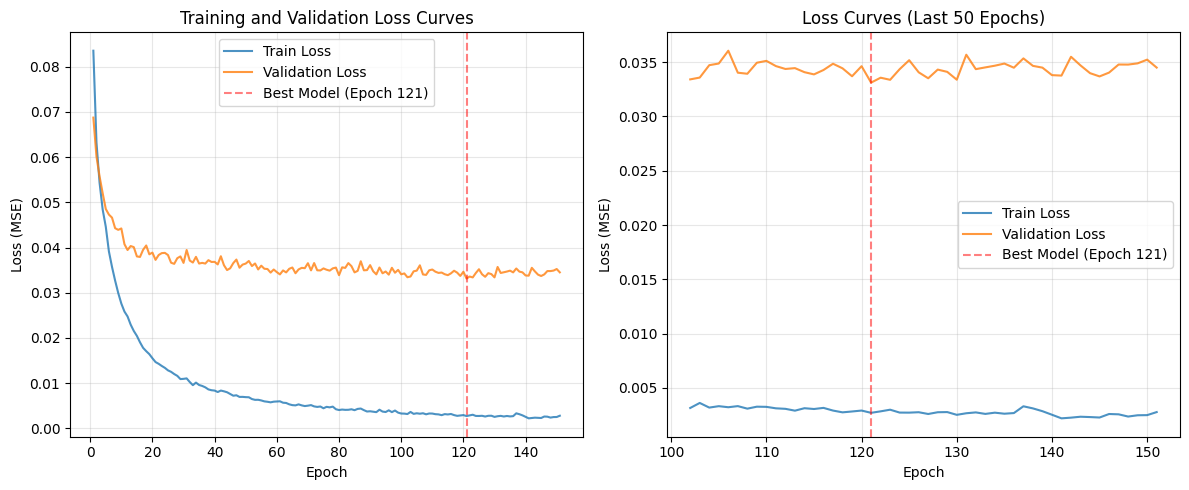

Final Training Loss: 0.002762
Final Validation Loss: 0.034504
Best Validation Loss: 0.033120 at Epoch 121


In [46]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
epochs_list = range(1, len(train_losses) + 1)
plt.plot(epochs_list, train_losses, label='Train Loss', alpha=0.8)
plt.plot(epochs_list, val_losses, label='Validation Loss', alpha=0.8)
if 'best_epoch' in locals():
    plt.axvline(x=best_epoch, color='r', linestyle='--', alpha=0.5, label=f'Best Model (Epoch {best_epoch})')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
if len(train_losses) > 20:
    start_idx = max(0, len(train_losses) - 50)
    plt.plot(epochs_list[start_idx:], train_losses[start_idx:], label='Train Loss', alpha=0.8)
    plt.plot(epochs_list[start_idx:], val_losses[start_idx:], label='Validation Loss', alpha=0.8)
    if 'best_epoch' in locals() and best_epoch > start_idx:
        plt.axvline(x=best_epoch, color='r', linestyle='--', alpha=0.5, label=f'Best Model (Epoch {best_epoch})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Loss Curves (Last 50 Epochs)')
else:
    plt.plot(epochs_list, train_losses, label='Train Loss', alpha=0.8)
    plt.plot(epochs_list, val_losses, label='Validation Loss', alpha=0.8)
    if 'best_epoch' in locals():
        plt.axvline(x=best_epoch, color='r', linestyle='--', alpha=0.5, label=f'Best Model (Epoch {best_epoch})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Loss Curves')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final Training Loss: {train_losses[-1]:.6f}")
print(f"Final Validation Loss: {val_losses[-1]:.6f}")
if 'best_val_loss' in locals():
    print(f"Best Validation Loss: {best_val_loss:.6f} at Epoch {best_epoch}")


Device: cuda

=== Test Set Evaluation ===
Samples: 3091
R²   : 0.5716
MAE  : 0.1383
RMSE : 0.1974


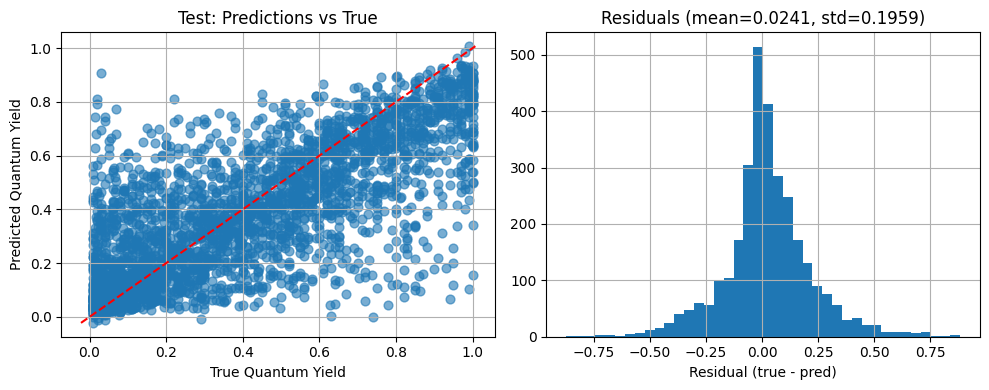

In [47]:
import os
import torch
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


if 'transformer_model' not in locals():
    input_dim = chrom_emb_scaled.shape[1]
    transformer_model = TransformerRegressor(input_dim=input_dim, hidden_dim=256, num_heads=8, num_layers=2).to(device)

    ckpt_path = "models/transformer_best.pth"
    if os.path.exists(ckpt_path):
        transformer_model.load_state_dict(torch.load(ckpt_path, map_location=device))
        print(f"Loaded checkpoint: {ckpt_path}")
    else:
        print("Warning: No trained model found. Please run Cell 13 first to train the model.")

transformer_model.eval()
y_true_list, y_pred_list = [], []

with torch.no_grad():
    for chrom_batch, solv_batch, yb in test_loader:
        chrom_batch = chrom_batch.to(device)
        solv_batch  = solv_batch.to(device)
        yb = yb.to(device)

        pred = transformer_model(chrom_batch, solv_batch) 
        y_true_list.append(yb.cpu())
        y_pred_list.append(pred.cpu())

y_true = torch.cat(y_true_list).squeeze().numpy()
y_pred = torch.cat(y_pred_list).squeeze().numpy()

r2  = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse= np.sqrt(mean_squared_error(y_true, y_pred))

print("\n=== Test Set Evaluation ===")
print(f"Samples: {len(y_true)}")
print(f"R²   : {r2:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(y_true, y_pred, alpha=0.6, s=40)
mn, mx = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
plt.plot([mn, mx], [mn, mx], 'r--')
plt.xlabel("True Quantum Yield")
plt.ylabel("Predicted Quantum Yield")
plt.title("Test: Predictions vs True")
plt.grid(True)

plt.subplot(1,2,2)
residuals = y_true - y_pred
plt.hist(residuals, bins=40)
plt.xlabel("Residual (true - pred)")
plt.title(f"Residuals (mean={residuals.mean():.4f}, std={residuals.std():.4f})")
plt.grid(True)

plt.tight_layout()
plt.show()

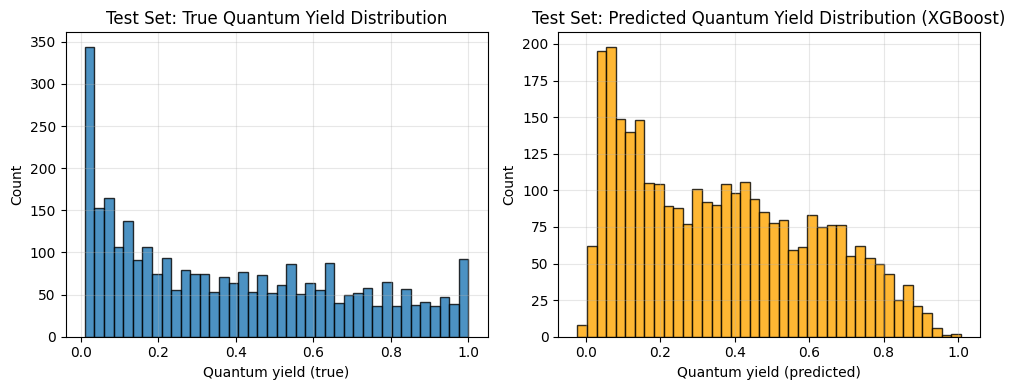

In [48]:

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(y_true, bins=40, alpha=0.8, edgecolor="black")
plt.xlabel("Quantum yield (true)")
plt.ylabel("Count")
plt.title("Test Set: True Quantum Yield Distribution")
plt.grid(True, alpha=0.3)

plt.subplot(1,2,2)
plt.hist(y_pred, bins=40, alpha=0.8, edgecolor="black", color="orange")
plt.xlabel("Quantum yield (predicted)")
plt.ylabel("Count")
plt.title("Test Set: Predicted Quantum Yield Distribution (XGBoost)")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



=== Improved Transformer Test Set Evaluation ===
Samples: 3091
R²   : 0.5904
MAE  : 0.1331
RMSE : 0.1930


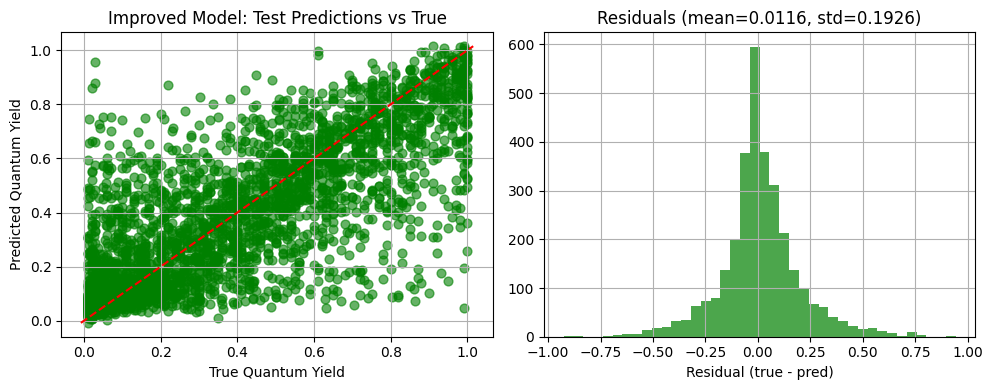

In [49]:

print("\n" + "="*50)
print("=== Improved Transformer Test Set Evaluation ===")
print("="*50)


if 'transformer_improved' not in locals():
    input_dim = chrom_emb_scaled.shape[1]
    transformer_improved = TransformerRegressorImproved(input_dim=input_dim, hidden_dim=256, num_heads=8, num_layers=2, dropout=0.3).to(device)
    ckpt_path = "models/transformer_improved_best.pth"
    if os.path.exists(ckpt_path):
        transformer_improved.load_state_dict(torch.load(ckpt_path, map_location=device))
        print(f"Loaded checkpoint: {ckpt_path}")
    else:
        print("Warning: No trained improved model found. Please run Cell 14 first.")

transformer_improved.eval()
y_true_improved_list, y_pred_improved_list = [], []

with torch.no_grad():
    for chrom_batch, solv_batch, yb in test_loader:
        chrom_batch = chrom_batch.to(device)
        solv_batch  = solv_batch.to(device)
        yb = yb.to(device)

        pred = transformer_improved(chrom_batch, solv_batch)
        y_true_improved_list.append(yb.cpu())
        y_pred_improved_list.append(pred.cpu())

y_true_improved = torch.cat(y_true_improved_list).squeeze().numpy()
y_pred_improved = torch.cat(y_pred_improved_list).squeeze().numpy()

r2_improved  = r2_score(y_true_improved, y_pred_improved)
mae_improved = mean_absolute_error(y_true_improved, y_pred_improved)
rmse_improved = np.sqrt(mean_squared_error(y_true_improved, y_pred_improved))

print(f"Samples: {len(y_true_improved)}")
print(f"R²   : {r2_improved:.4f}")
print(f"MAE  : {mae_improved:.4f}")
print(f"RMSE : {rmse_improved:.4f}")

# Plots
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(y_true_improved, y_pred_improved, alpha=0.6, s=40, color='green')
mn, mx = min(y_true_improved.min(), y_pred_improved.min()), max(y_true_improved.max(), y_pred_improved.max())
plt.plot([mn, mx], [mn, mx], 'r--')
plt.xlabel("True Quantum Yield")
plt.ylabel("Predicted Quantum Yield")
plt.title("Improved Model: Test Predictions vs True")
plt.grid(True)

plt.subplot(1,2,2)
residuals_improved = y_true_improved - y_pred_improved
plt.hist(residuals_improved, bins=40, color='green', alpha=0.7)
plt.xlabel("Residual (true - pred)")
plt.title(f"Residuals (mean={residuals_improved.mean():.4f}, std={residuals_improved.std():.4f})")
plt.grid(True)

plt.tight_layout()
plt.show()


In [50]:

print("\n" + "="*50)
print("=== Improved Transformer Validation Results ===")
print("="*50)

transformer_improved.eval()
y_val_true_improved_list, y_val_pred_improved_list = [], []

with torch.no_grad():
    for chrom_batch, solv_batch, yb in val_loader:
        chrom_batch = chrom_batch.to(device)
        solv_batch  = solv_batch.to(device)
        yb = yb.to(device)

        pred = transformer_improved(chrom_batch, solv_batch)
        y_val_true_improved_list.append(yb.cpu())
        y_val_pred_improved_list.append(pred.cpu())

y_val_true_improved = torch.cat(y_val_true_improved_list).squeeze().numpy()
y_val_pred_improved = torch.cat(y_val_pred_improved_list).squeeze().numpy()

r2_val_improved  = r2_score(y_val_true_improved, y_val_pred_improved)
mae_val_improved = mean_absolute_error(y_val_true_improved, y_val_pred_improved)
rmse_val_improved = np.sqrt(mean_squared_error(y_val_true_improved, y_val_pred_improved))

print(f"Samples: {len(y_val_true_improved)}")
print(f"R²   : {r2_val_improved:.4f}")
print(f"MAE  : {mae_val_improved:.4f}")
print(f"RMSE : {rmse_val_improved:.4f}")


print("\n" + "="*50)
print("=== Improved Transformer Train Set Evaluation ===")
print("="*50)

transformer_improved.eval()
y_train_true_improved_list, y_train_pred_improved_list = [], []

with torch.no_grad():
    for chrom_batch, solv_batch, yb in train_loader:
        chrom_batch = chrom_batch.to(device)
        solv_batch  = solv_batch.to(device)
        yb = yb.to(device)

        pred = transformer_improved(chrom_batch, solv_batch)
        y_train_true_improved_list.append(yb.cpu())
        y_train_pred_improved_list.append(pred.cpu())

y_train_true_improved = torch.cat(y_train_true_improved_list).squeeze().numpy()
y_train_pred_improved = torch.cat(y_train_pred_improved_list).squeeze().numpy()

r2_train_improved  = r2_score(y_train_true_improved, y_train_pred_improved)
mae_train_improved = mean_absolute_error(y_train_true_improved, y_train_pred_improved)
rmse_train_improved = np.sqrt(mean_squared_error(y_train_true_improved, y_train_pred_improved))

print(f"Samples: {len(y_train_true_improved)}")
print(f"R²   : {r2_train_improved:.4f}")
print(f"MAE  : {mae_train_improved:.4f}")
print(f"RMSE : {rmse_train_improved:.4f}")



=== Improved Transformer Validation Results ===
Samples: 1546
R²   : 0.6316
MAE  : 0.1257
RMSE : 0.1822

=== Improved Transformer Train Set Evaluation ===
Samples: 10816
R²   : 0.9722
MAE  : 0.0377
RMSE : 0.0505



COMPREHENSIVE MODEL COMPARISON: ORIGINAL vs IMPROVED

=== Performance Metrics Comparison ===
   Model        Set  Samples       R²      MAE     RMSE
Original      Train    10816 0.979195 0.032107 0.043710
Original Validation     1546 0.610068 0.128295 0.187459
Original       Test     3091 0.571599 0.138332 0.197361
Improved      Train    10816 0.972209 0.037742 0.050518
Improved Validation     1546 0.631611 0.125652 0.182207
Improved       Test     3091 0.590362 0.133133 0.192990

=== Overfitting Analysis ===
Original Model:
  Train-Val R² gap: 0.3691
  Train-Val RMSE gap: 0.1437
  Train-Test R² gap: 0.4076
  Train-Test RMSE gap: 0.1537

Improved Model:
  Train-Val R² gap: 0.3406
  Train-Val RMSE gap: 0.1317
  Train-Test R² gap: 0.3818
  Train-Test RMSE gap: 0.1425

=== Improvement Analysis ===
Test Set Improvements:
  R² improvement: +0.0188 (+3.28%)
  MAE improvement: -0.0052 (-3.76%)
  RMSE improvement: -0.0044 (-2.21%)

Validation Set Improvements:
  R² improvement: +0.0215 (+3.53

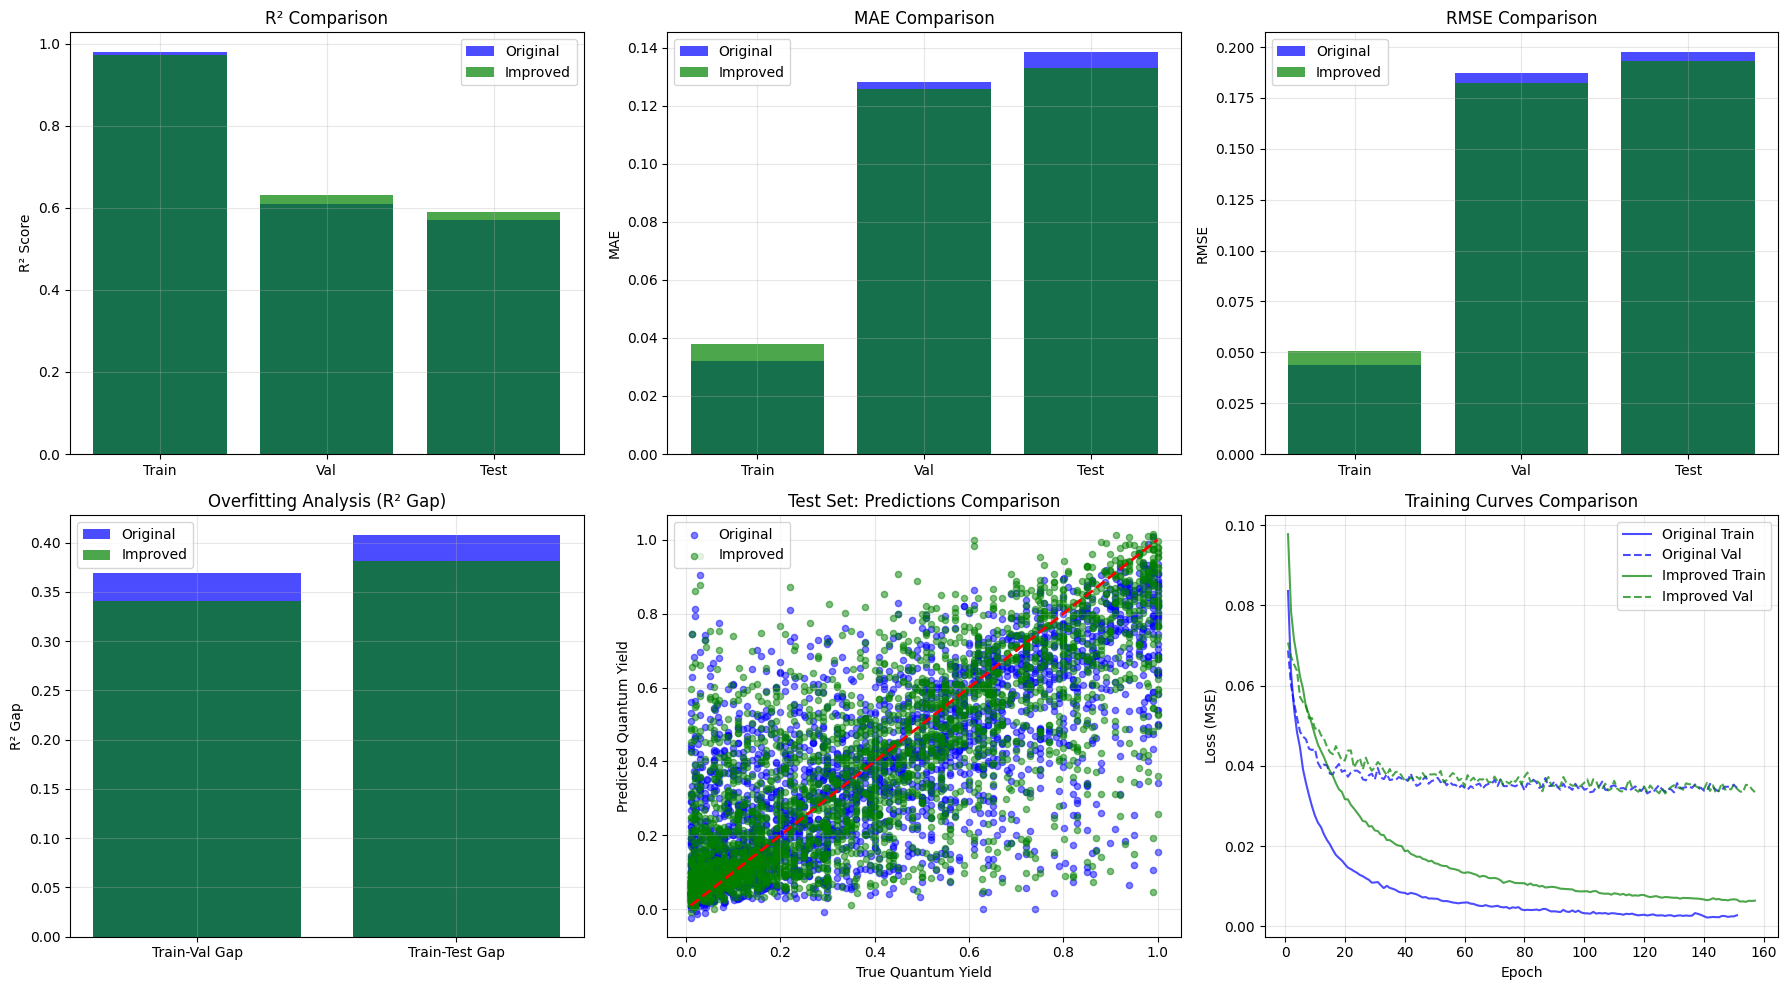


Comparison Complete!


In [51]:

print("\n" + "="*70)
print("="*70)
print("COMPREHENSIVE MODEL COMPARISON: ORIGINAL vs IMPROVED")
print("="*70)
print("="*70)


comparison_df = pd.DataFrame({
    "Model": ["Original", "Original", "Original", "Improved", "Improved", "Improved"],
    "Set": ["Train", "Validation", "Test", "Train", "Validation", "Test"],
    "Samples": [len(y_train_true), len(y_val_true), len(y_true), 
                len(y_train_true_improved), len(y_val_true_improved), len(y_true_improved)],
    "R²": [r2_train, r2_val, r2, r2_train_improved, r2_val_improved, r2_improved],
    "MAE": [mae_train, mae_val, mae, mae_train_improved, mae_val_improved, mae_improved],
    "RMSE": [rmse_train, rmse_val, rmse, rmse_train_improved, rmse_val_improved, rmse_improved]
})

print("\n=== Performance Metrics Comparison ===")
print(comparison_df.to_string(index=False))


print("\n=== Overfitting Analysis ===")
print(f"Original Model:")
print(f"  Train-Val R² gap: {r2_train - r2_val:.4f}")
print(f"  Train-Val RMSE gap: {rmse_val - rmse_train:.4f}")
print(f"  Train-Test R² gap: {r2_train - r2:.4f}")
print(f"  Train-Test RMSE gap: {rmse - rmse_train:.4f}")

print(f"\nImproved Model:")
print(f"  Train-Val R² gap: {r2_train_improved - r2_val_improved:.4f}")
print(f"  Train-Val RMSE gap: {rmse_val_improved - rmse_train_improved:.4f}")
print(f"  Train-Test R² gap: {r2_train_improved - r2_improved:.4f}")
print(f"  Train-Test RMSE gap: {rmse_improved - rmse_train_improved:.4f}")


print("\n=== Improvement Analysis ===")
print(f"Test Set Improvements:")
print(f"  R² improvement: {r2_improved - r2:+.4f} ({((r2_improved - r2) / abs(r2) * 100):+.2f}%)")
print(f"  MAE improvement: {mae_improved - mae:+.4f} ({((mae_improved - mae) / mae * 100):+.2f}%)")
print(f"  RMSE improvement: {rmse_improved - rmse:+.4f} ({((rmse_improved - rmse) / rmse * 100):+.2f}%)")

print(f"\nValidation Set Improvements:")
print(f"  R² improvement: {r2_val_improved - r2_val:+.4f} ({((r2_val_improved - r2_val) / abs(r2_val) * 100):+.2f}%)")
print(f"  MAE improvement: {mae_val_improved - mae_val:+.4f} ({((mae_val_improved - mae_val) / mae_val * 100):+.2f}%)")
print(f"  RMSE improvement: {rmse_val_improved - rmse_val:+.4f} ({((rmse_val_improved - rmse_val) / rmse_val * 100):+.2f}%)")


fig, axes = plt.subplots(2, 3, figsize=(18, 10))


axes[0, 0].bar(['Train', 'Val', 'Test'], [r2_train, r2_val, r2], alpha=0.7, label='Original', color='blue')
axes[0, 0].bar(['Train', 'Val', 'Test'], [r2_train_improved, r2_val_improved, r2_improved], 
               alpha=0.7, label='Improved', color='green')
axes[0, 0].set_ylabel('R² Score')
axes[0, 0].set_title('R² Comparison')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)


axes[0, 1].bar(['Train', 'Val', 'Test'], [mae_train, mae_val, mae], alpha=0.7, label='Original', color='blue')
axes[0, 1].bar(['Train', 'Val', 'Test'], [mae_train_improved, mae_val_improved, mae_improved], 
               alpha=0.7, label='Improved', color='green')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].set_title('MAE Comparison')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)


axes[0, 2].bar(['Train', 'Val', 'Test'], [rmse_train, rmse_val, rmse], alpha=0.7, label='Original', color='blue')
axes[0, 2].bar(['Train', 'Val', 'Test'], [rmse_train_improved, rmse_val_improved, rmse_improved], 
               alpha=0.7, label='Improved', color='green')
axes[0, 2].set_ylabel('RMSE')
axes[0, 2].set_title('RMSE Comparison')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)


train_val_gap_orig = r2_train - r2_val
train_test_gap_orig = r2_train - r2
train_val_gap_imp = r2_train_improved - r2_val_improved
train_test_gap_imp = r2_train_improved - r2_improved

axes[1, 0].bar(['Train-Val Gap', 'Train-Test Gap'], [train_val_gap_orig, train_test_gap_orig], 
               alpha=0.7, label='Original', color='blue')
axes[1, 0].bar(['Train-Val Gap', 'Train-Test Gap'], [train_val_gap_imp, train_test_gap_imp], 
               alpha=0.7, label='Improved', color='green')
axes[1, 0].set_ylabel('R² Gap')
axes[1, 0].set_title('Overfitting Analysis (R² Gap)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)


axes[1, 1].scatter(y_true, y_pred, alpha=0.5, s=20, label='Original', color='blue')
axes[1, 1].scatter(y_true_improved, y_pred_improved, alpha=0.5, s=20, label='Improved', color='green')
mn, mx = min(y_true.min(), y_true_improved.min()), max(y_true.max(), y_true_improved.max())
axes[1, 1].plot([mn, mx], [mn, mx], 'r--', lw=2)
axes[1, 1].set_xlabel('True Quantum Yield')
axes[1, 1].set_ylabel('Predicted Quantum Yield')
axes[1, 1].set_title('Test Set: Predictions Comparison')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)


if 'train_losses' in locals() and 'train_losses_improved' in locals():
    epochs_orig = range(1, len(train_losses) + 1)
    epochs_imp = range(1, len(train_losses_improved) + 1)
    axes[1, 2].plot(epochs_orig, train_losses, label='Original Train', color='blue', alpha=0.7)
    axes[1, 2].plot(epochs_orig, val_losses, label='Original Val', color='blue', linestyle='--', alpha=0.7)
    axes[1, 2].plot(epochs_imp, train_losses_improved, label='Improved Train', color='green', alpha=0.7)
    axes[1, 2].plot(epochs_imp, val_losses_improved, label='Improved Val', color='green', linestyle='--', alpha=0.7)
    axes[1, 2].set_xlabel('Epoch')
    axes[1, 2].set_ylabel('Loss (MSE)')
    axes[1, 2].set_title('Training Curves Comparison')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)
else:
    axes[1, 2].text(0.5, 0.5, 'Run training cells to see loss curves', 
                    ha='center', va='center', transform=axes[1, 2].transAxes)
    axes[1, 2].set_title('Training Curves (not available)')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("Comparison Complete!")
print("="*70)



=== Transformer/CrossAttention Validation Results ===
Samples: 1546
R²   : 0.6180
MAE  : 0.1281
RMSE : 0.1855


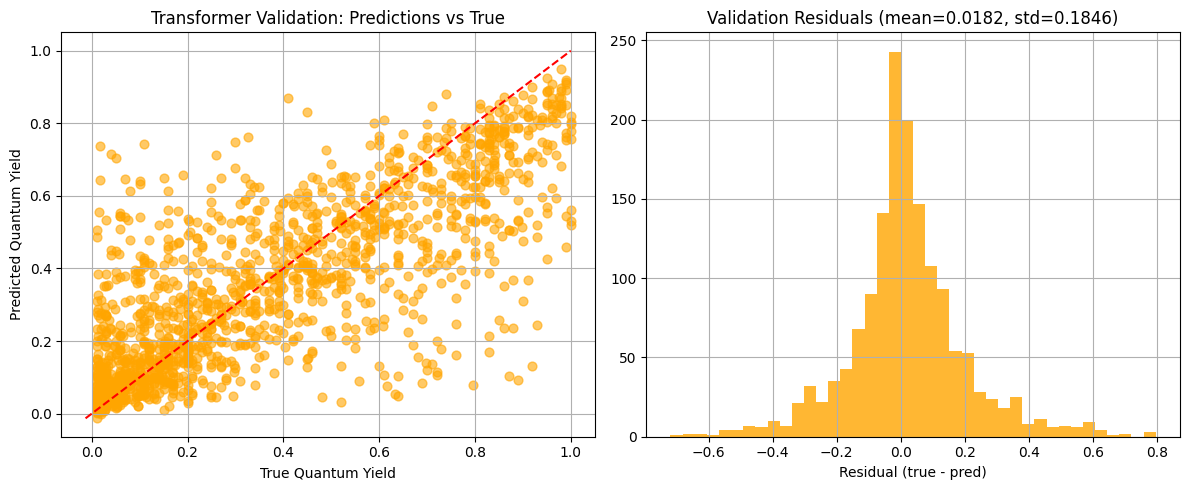

In [52]:
print("\n" + "="*50)
print("=== Transformer/CrossAttention Validation Results ===")
print("="*50)

transformer_model.eval()
y_val_true_list, y_val_pred_list = [], []

with torch.no_grad():
    for chrom_batch, solv_batch, yb in val_loader:
        chrom_batch = chrom_batch.to(device)
        solv_batch  = solv_batch.to(device)
        yb = yb.to(device)

        pred = transformer_model(chrom_batch, solv_batch)
        y_val_true_list.append(yb.cpu())
        y_val_pred_list.append(pred.cpu())

y_val_true = torch.cat(y_val_true_list).squeeze().numpy()
y_val_pred = torch.cat(y_val_pred_list).squeeze().numpy()

r2_val  = r2_score(y_val_true, y_val_pred)
mae_val = mean_absolute_error(y_val_true, y_val_pred)
rmse_val = np.sqrt(mean_squared_error(y_val_true, y_val_pred))

print(f"Samples: {len(y_val_true)}")
print(f"R²   : {r2_val:.4f}")
print(f"MAE  : {mae_val:.4f}")
print(f"RMSE : {rmse_val:.4f}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_val_true, y_val_pred, alpha=0.6, s=40, color='orange')
mn, mx = min(y_val_true.min(), y_val_pred.min()), max(y_val_true.max(), y_val_pred.max())
plt.plot([mn, mx], [mn, mx], 'r--', lw=1.5)
plt.xlabel("True Quantum Yield")
plt.ylabel("Predicted Quantum Yield")
plt.title("Transformer Validation: Predictions vs True")
plt.grid(True)

plt.subplot(1, 2, 2)
residuals_val = y_val_true - y_val_pred
plt.hist(residuals_val, bins=40, alpha=0.8, color='orange')
plt.xlabel("Residual (true - pred)")
plt.title(f"Validation Residuals (mean={residuals_val.mean():.4f}, std={residuals_val.std():.4f})")
plt.grid(True)

plt.tight_layout()
plt.show()


In [53]:
print("\n" + "="*50)
print("=== Train Set Evaluation ===")
print("="*50)

transformer_model.eval()
y_train_true_list, y_train_pred_list = [], []

with torch.no_grad():
    for chrom_batch, solv_batch, yb in train_loader:
        chrom_batch = chrom_batch.to(device)
        solv_batch  = solv_batch.to(device)
        yb = yb.to(device)

        pred = transformer_model(chrom_batch, solv_batch)
        y_train_true_list.append(yb.cpu())
        y_train_pred_list.append(pred.cpu())

y_train_true = torch.cat(y_train_true_list).squeeze().numpy()
y_train_pred = torch.cat(y_train_pred_list).squeeze().numpy()

r2_train  = r2_score(y_train_true, y_train_pred)
mae_train = mean_absolute_error(y_train_true, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train_true, y_train_pred))

print(f"Samples: {len(y_train_true)}")
print(f"R²   : {r2_train:.4f}")
print(f"MAE  : {mae_train:.4f}")
print(f"RMSE : {rmse_train:.4f}")


comparison_df = pd.DataFrame({
    "Set": ["Train", "Validation", "Test"],
    "Samples": [len(y_train_true), len(y_val_true), len(y_true)],
    "R²": [r2_train, r2_val, r2],
    "MAE": [mae_train, mae_val, mae],
    "RMSE": [rmse_train, rmse_val, rmse]
})

print("\n" + "="*50)
print("=== Model Performance Comparison ===")
print("="*50)
print(comparison_df.to_string(index=False))



=== Train Set Evaluation ===
Samples: 10816
R²   : 0.9774
MAE  : 0.0333
RMSE : 0.0456

=== Model Performance Comparison ===
       Set  Samples       R²      MAE     RMSE
     Train    10816 0.977351 0.033270 0.045606
Validation     1546 0.618017 0.128063 0.185538
      Test     3091 0.571599 0.138332 0.197361
